In [ ]:
import os

# Проверяем подсоединён ли гугл диск
if os.path.exists("drive") and os.path.isdir("drive"):
    print("Google Диск подключён")
else:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Проверяем папку с данными
if os.path.exists("neuron_data") and os.path.isdir("neuron_data"):
    print("Данные уже на локальном хранилище")
else:
    !mkdir neuron_data
    !unzip drive/MyDrive/neuron_data/toronto.zip -d neuron_data/tess
    !unzip drive/MyDrive/neuron_data/cremad.zip -d neuron_data/cremad
    !unzip drive/MyDrive/neuron_data/ravdess.zip -d neuron_data/ravdess
    !unzip drive/MyDrive/neuron_data/savee.zip -d neuron_data/savee

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# пути до датасетов
crema_path = "neuron_data/cremad/AudioWAV"
ravdess_path = "neuron_data/ravdess/audio_speech_actors_01-24"
tess_path = "neuron_data/tess"
savee_path = "neuron_data/savee/ALL"

In [ ]:
# ravdess датасет
ravdess_directory_list = os.listdir(ravdess_path)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # так как в предыдущей папке 20 разных актёров
    # мы должны достать файлы для каждого актёра
    actor = os.path.join(ravdess_path, dir)
    for file in os.listdir(actor):
        filename = file.split(".")[0]
        name_splited = filename.split("-")
        # третья часть в названии файла обозначает соответствующую эмоцию
        file_emotion.append(int(name_splited[2]))
        f_path = os.path.join(ravdess_path, dir, file)
        file_path.append(f_path)
# датафрейм для эмоций файлов
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])
# датафрейм для путей файлов
path_df = pd.DataFrame(file_path, columns=["Path"])
# объединяем
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# заменяем числа на названия эмоций
Ravdess_df.Emotions.replace(
    {
        1: "neutral",
        2: "neutral",
        3: "happy",
        4: "sad",
        5: "angry",
        6: "fear",
        7: "disgust",
        8: "surprise",
    },
    inplace=True,
)
Ravdess_df.Emotions.value_counts()

neutral     288
angry       192
surprise    192
sad         192
happy       192
fear        192
disgust     192
Name: Emotions, dtype: int64

In [ ]:
# crema датасет
crema_directory = os.listdir(crema_path)
file_path = []
file_emotion = []
for filename in crema_directory:
    # разделяем на всякий случай для каждой характеристики
    actor, phrase, emotion, emotion_level = filename.removesuffix(".wav").split("_")
    f_path = os.path.join(crema_path, filename)
    file_path.append(f_path)
    if emotion == "ANG":
        file_emotion.append("angry")
    elif emotion == "DIS":
        file_emotion.append("disgust")
    elif emotion == "FEA":
        file_emotion.append("fear")
    elif emotion == "HAP":
        file_emotion.append("happy")
    elif emotion == "NEU":
        file_emotion.append("neutral")
    elif emotion == "SAD":
        file_emotion.append("sad")
    else:
        file_emotion.append("unknown")
# датафрейм для эмоций файлов
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])
# датафрейм для путей файлов
paths_df = pd.DataFrame(file_path, columns=["Path"])
Crema_df = pd.concat([emotion_df, paths_df], axis=1)
Crema_df.Emotions.value_counts()

happy      1271
disgust    1271
angry      1271
sad        1271
fear       1271
neutral    1087
Name: Emotions, dtype: int64

In [ ]:
# TESS датасет
tess_directory_list = os.listdir(tess_path)
file_emotion = []
file_path = []
for dir in tess_directory_list:
    path = os.path.join(tess_path, dir)
    directories = os.listdir(path)
    for file in directories:
        part = file.split(".")[0]
        part = part.split("_")[2]
        if part == "ps":
            file_emotion.append("surprise")
        else:
            file_emotion.append(part)
        f_path = os.path.join(tess_path, dir, file)
        file_path.append(f_path)
# датафрейм для эмоций файлов
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])
# датафрейм для путей файлов
path_df = pd.DataFrame(file_path, columns=["Path"])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.Emotions.value_counts()

angry       400
surprise    400
disgust     400
neutral     400
sad         400
fear        400
happy       400
Name: Emotions, dtype: int64

In [ ]:
# savee датасет
file_path = []
file_emotion = []
files = os.listdir(savee_path)
for filename in files:
    f_path = os.path.join(savee_path, filename)
    file_path.append(f_path)
    _actor, postfix = filename.removesuffix(".wav").split("_")
    emotion = postfix[:-2]
    if emotion == "a":
        file_emotion.append("angry")
    elif emotion == "d":
        file_emotion.append("disgust")
    elif emotion == "f":
        file_emotion.append("fear")
    elif emotion == "h":
        file_emotion.append("happy")
    elif emotion == "sa":
        file_emotion.append("sad")
    elif emotion == "su":
        file_emotion.append("surprise")
    else:
        file_emotion.append("neutral")
# датафрейм для эмоций файлов
emotion_df = pd.DataFrame(file_emotion, columns=["Emotions"])
# датафрейм для путей файлов
path_df = pd.DataFrame(file_path, columns=["Path"])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.Emotions.value_counts()

neutral     120
happy        60
sad          60
disgust      60
angry        60
surprise     60
fear         60
Name: Emotions, dtype: int64

In [ ]:
def make_waveplot(data, sampling_rate):
    # визуализация аудиофайла
    plt.figure(figsize=(14, 5))
    plt.title(f"Графическое представление аудиофайла", size=14)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.xlabel("Время, сек")
    plt.ylabel("Амплитуда")
    plt.show()

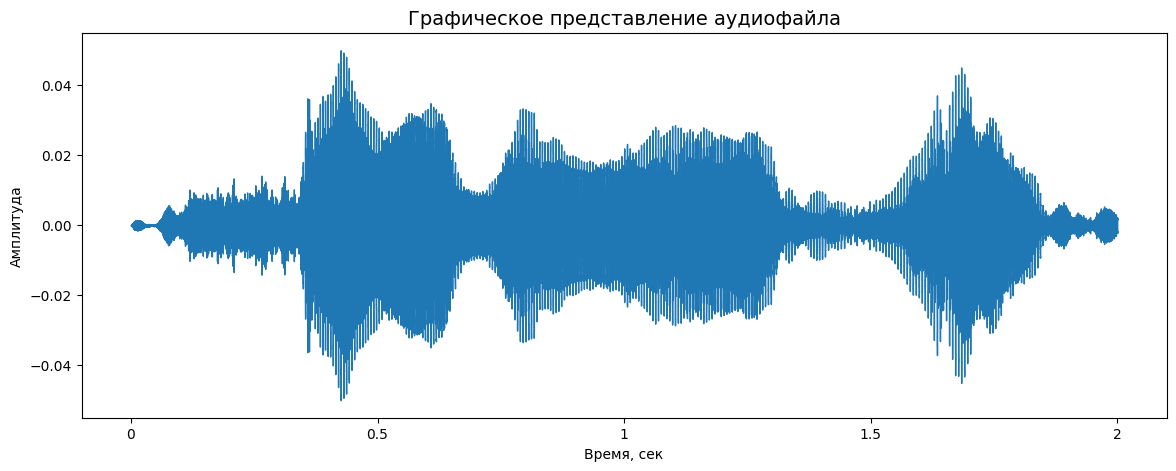

In [ ]:
# выбираем один аудиофайл и строим для него график
path = np.array(Tess_df.Path[Tess_df.Emotions == "neutral"])[0]
data_wav, sr = librosa.load(path)
make_waveplot(data_wav, sr)

In [ ]:
# сохраняем все датафреймы в csv таблицы
Savee_df.to_csv("drive/MyDrive/neuron_data/csv_tables/savee_path.csv", index=False)
Ravdess_df.to_csv("drive/MyDrive/neuron_data/csv_tables/ravdess_path.csv", index=False)
Tess_df.to_csv("drive/MyDrive/neuron_data/csv_tables/tess_path.csv", index=False)
Crema_df.to_csv("drive/MyDrive/neuron_data/csv_tables/crema_path.csv", index=False)
# создаём объединённый датафрейм для визуализации количества эмоций по классам
combined_df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

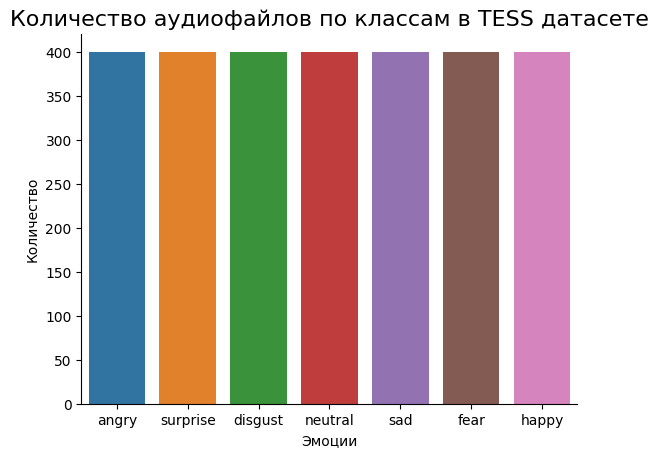

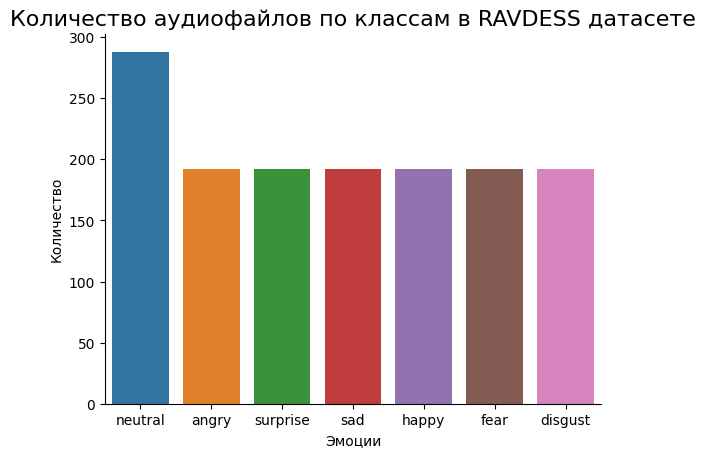

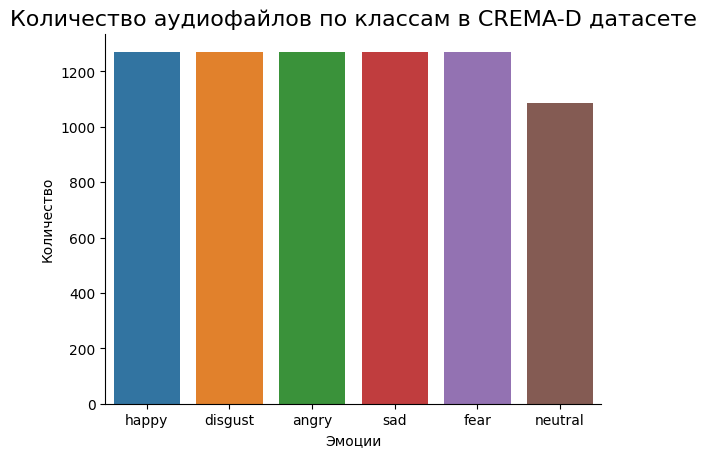

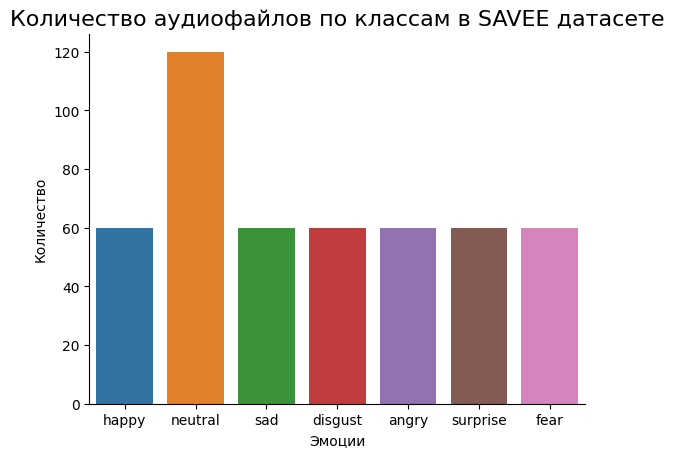

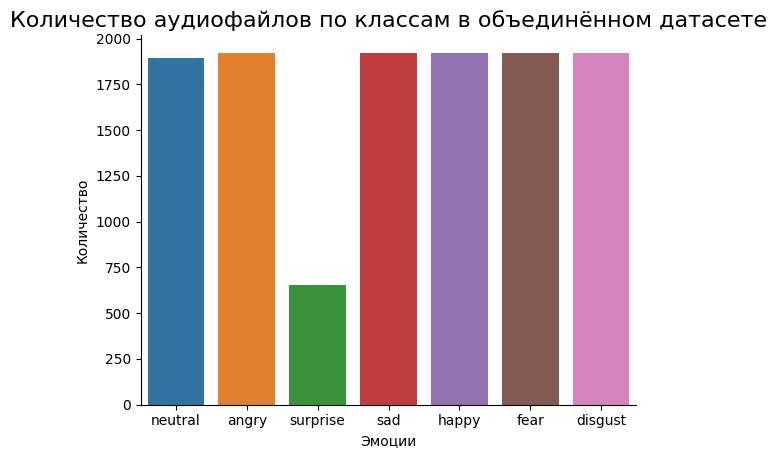

In [ ]:
def visualise_histogram(df, df_name):
    # визуализация гистограммой
    plt.title(f"Количество аудиофайлов по классам в {df_name} датасете", size=16)
    sns.countplot(x=df.Emotions)
    plt.xlabel("Эмоции", size=10)
    plt.ylabel("Количество", size=10)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.show()


visualise_histogram(Tess_df, "TESS")
visualise_histogram(Ravdess_df, "RAVDESS")
visualise_histogram(Crema_df, "CREMA-D")
visualise_histogram(Savee_df, "SAVEE")
visualise_histogram(combined_df, "объединённом")